In [19]:
from ema_workbench import (
    HypervolumeMetric,
    GenerationalDistanceMetric,
    EpsilonIndicatorMetric,
    InvertedGenerationalDistanceMetric,
    SpacingMetric,
)
from ema_workbench.em_framework.optimization import to_problem
import pandas as pd
import numpy as np
from ema_workbench import (Model, RealParameter, IntegerParameter, CategoricalParameter,
                           ScalarOutcome, perform_experiments, Samplers, Policy, Scenario)
from ema_workbench.em_framework import (SequentialEvaluator, MultiprocessingEvaluator)
from ema_workbench.util import ema_logging
from ema_workbench.em_framework.optimization import (EpsNSGAII, Convergence)
from ema_workbench.em_framework.optimization import (ArchiveLogger,Problem, EpsilonProgress)
from ema_workbench.analysis import parcoords
from dike_model_function import DikeNetwork

def sum_over(*args):
    numbers = []
    for entry in args:
        try:
            value = sum(entry)
        except TypeError:
            value = entry
        numbers.append(value)
    return sum(numbers)

def get_model_for_problem_formulation(problem_formulation_id):
    function = DikeNetwork()
    dike_model = Model("dikesnet", function=function)

    Real_uncert = {"Bmax": [30, 350], "pfail": [0, 1]}  # m and [.]
    cat_uncert_loc = {"Brate": (1.0, 1.5, 10)}
    cat_uncert = {f"discount rate {n}": (1.5, 2.5, 3.5, 4.5) for n in function.planning_steps}
    Int_uncert = {"A.0_ID flood wave shape": [0, 132]}

    uncertainties = []

    for uncert_name in cat_uncert.keys():
        categories = cat_uncert[uncert_name]
        uncertainties.append(CategoricalParameter(uncert_name, categories))

    for uncert_name in Int_uncert.keys():
        uncertainties.append(IntegerParameter(uncert_name, Int_uncert[uncert_name][0], Int_uncert[uncert_name][1]))

    dike_height_levers = []
    for dike in function.dikelist:
        for uncert_name in Real_uncert.keys():
            name = f"{dike}_{uncert_name}"
            lower, upper = Real_uncert[uncert_name]
            uncertainties.append(RealParameter(name, lower, upper))

        for uncert_name in cat_uncert_loc.keys():
            name = f"{dike}_{uncert_name}"
            categories = cat_uncert_loc[uncert_name]
            uncertainties.append(CategoricalParameter(name, categories))

        for n in function.planning_steps:
            name = f"{dike}_DikeIncrease {n}"
            dike_height_levers.append(IntegerParameter(name, 0, 10))

    dike_model.uncertainties = uncertainties

    dike_height_levers.append(IntegerParameter("EWS_DaysToThreat", 0, 4))  # days
    # Set levers: No RfR, dike heightening
    dike_model.levers = dike_height_levers

    # Define the outcomes
    outcomes = [
        ScalarOutcome('Total Costs', kind=ScalarOutcome.MINIMIZE, function=sum_over, variable_name=[
            f"{dike}_Expected Annual Damage" for dike in function.dikelist] +
                      [f"{dike}_Dike Investment Costs" for dike in function.dikelist] +
                      ["RfR Total Costs"]
        ),
        ScalarOutcome('Expected Number of Deaths', kind=ScalarOutcome.MINIMIZE, function=sum_over, variable_name=[
            f"{dike}_Expected Number of Deaths" for dike in function.dikelist]
        ),
        ScalarOutcome('Expected Annual Damage', kind=ScalarOutcome.MINIMIZE, function=sum_over, variable_name=[
            f"{dike}_Expected Annual Damage" for dike in function.dikelist]),
        ScalarOutcome('Dike Investment Costs', kind=ScalarOutcome.MINIMIZE, function=sum_over,
                      variable_name=[f"{dike}_Dike Investment Costs" for dike in function.dikelist])
    ]

    dike_model.outcomes = outcomes

    return dike_model
# Get the model for a specific problem formulation
problem_formulation_id = 6  # Change this to the desired problem formulation
dike_model = get_model_for_problem_formulation(problem_formulation_id)


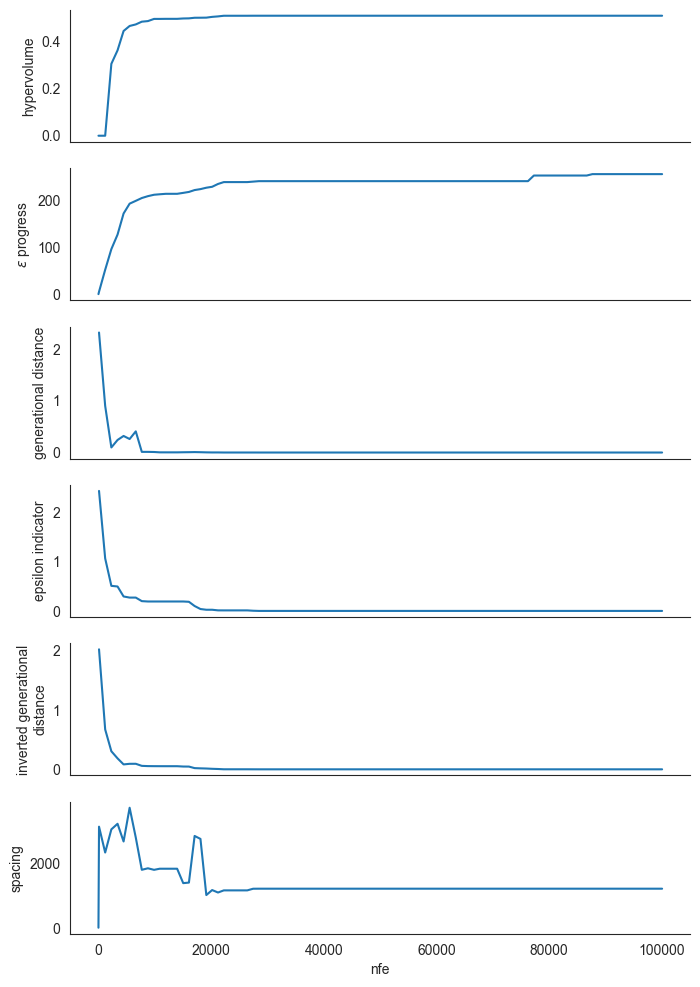

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ema_workbench import (
    HypervolumeMetric,
    GenerationalDistanceMetric,
    EpsilonIndicatorMetric,
    InvertedGenerationalDistanceMetric,
    SpacingMetric,
)
from ema_workbench.em_framework.optimization import to_problem

# Load convergence metrics
convergence = pd.read_csv('convergence_metrics_singlerun.csv')

# Load archives
archives = ArchiveLogger.load_archives(f"./archives/single_run.tar.gz")

# Prepare the data
for key in archives:
    archives[key] = archives[key].drop('Unnamed: 0', axis=1)

reference_set = archives[max(archives.keys())]  # this is the final archive

# Calculate metrics
def calculate_metrics(archives, reference_set):
    problem = to_problem(dike_model, searchover="levers")

    hv = HypervolumeMetric(reference_set, problem)
    gd = GenerationalDistanceMetric(reference_set, problem, d=1)
    ei = EpsilonIndicatorMetric(reference_set, problem)
    ig = InvertedGenerationalDistanceMetric(reference_set, problem, d=1)
    sm = SpacingMetric(problem)

    metrics = []
    for nfe, archive in archives.items():
        scores = {
            "generational_distance": gd.calculate(archive),
            "hypervolume": hv.calculate(archive),
            "epsilon_indicator": ei.calculate(archive),
            "inverted_gd": ig.calculate(archive),
            "spacing": sm.calculate(archive),
            "nfe": int(nfe),
        }
        metrics.append(scores)
    metrics = pd.DataFrame.from_dict(metrics)

    # sort metrics by number of function evaluations
    metrics.sort_values(by="nfe", inplace=True)
    return metrics

metrics = calculate_metrics(archives, reference_set)

# Plot metrics
def plot_metrics(metrics, convergence):
    sns.set_style("white")
    fig, axes = plt.subplots(nrows=6, figsize=(8, 12), sharex=True)

    ax1, ax2, ax3, ax4, ax5, ax6 = axes

    ax1.plot(metrics.nfe, metrics.hypervolume)
    ax1.set_ylabel("hypervolume")

    ax2.plot(convergence.nfe, convergence.epsilon_progress)
    ax2.set_ylabel("$\epsilon$ progress")

    ax3.plot(metrics.nfe, metrics.generational_distance)
    ax3.set_ylabel("generational distance")

    ax4.plot(metrics.nfe, metrics.epsilon_indicator)
    ax4.set_ylabel("epsilon indicator")

    ax5.plot(metrics.nfe, metrics.inverted_gd)
    ax5.set_ylabel("inverted generational\ndistance")

    ax6.plot(metrics.nfe, metrics.spacing)
    ax6.set_ylabel("spacing")

    ax6.set_xlabel("nfe")

    sns.despine(fig)

# Plot the metrics
plot_metrics(metrics, convergence)

plt.show()


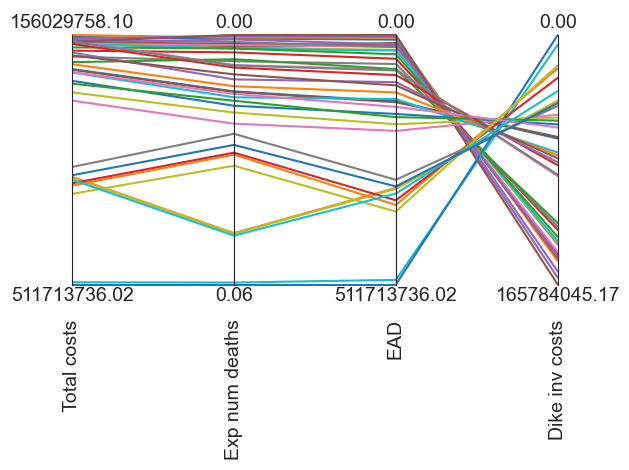

In [2]:
import pandas as pd
import seaborn as sns
from ema_workbench.analysis import parcoords
import matplotlib.pyplot as plt

# Load the optimization results
result_df = pd.read_csv('optimization_outcomes_singlerun.csv')

# Define the columns to plot
columns_to_plot = ['Total Costs', 'Expected Number of Deaths', 'Expected Annual Damage', 'Dike Investment Costs']
custom_column_names = ['Total costs', 'Exp num deaths', 'EAD', 'Dike inv costs']

# Ensure the columns are present in the results
present_columns = [col for col in columns_to_plot if col in result_df.columns]

# Rename the outcomes columns for better readability
outcomes = result_df[present_columns]
outcomes.columns = custom_column_names

# Define limits for parallel coordinates plot
limits = parcoords.get_limits(outcomes)

# Create parallel axes
axes = parcoords.ParallelAxes(limits)

# Plot the outcomes
axes.plot(outcomes)

# Invert the axis for outcomes where lower values are better
for col in custom_column_names:
    axes.invert_axis(col)

# Display the plot
plt.show()


In [13]:
result_df.head(10)

#Let us now inspect options where the number of deaths is very low (expected number of deaths lower than 0.001) and the Dike investment costs are lowest
result_final = result_df[result_df['Expected Number of Deaths']<0.001]
result_final.sort_values('Dike Investment Costs', ascending=True)


,Total Costs,Expected Number of Deaths,Expected Annual Damage,Dike Investment Costs
0,1.588294e+08,0.000926,9.644546e+06,1.491849e+08
1,1.560298e+08,0.000669,5.723542e+06,1.503062e+08
4,1.612604e+08,0.000282,4.164666e+06,1.570958e+08
14,1.631057e+08,0.000130,1.862959e+06,1.612427e+08
25,1.657840e+08,0.000000,0.000000e+00,1.657840e+08


In [7]:
import pandas as pd

# Load the DataFrame
policy_df = pd.read_csv('optimization_policies_singlerun.csv')

print('The policy outcome is:')
# Print the column names and values of the first row, except the last four columns
first_row = policy_df.iloc[0]
for column, value in first_row[:-4].items():
    print(f"{column}: {value}")


The policy outcome is:
A.1_DikeIncrease 0: 2.0
A.1_DikeIncrease 1: 0.0
A.1_DikeIncrease 2: 0.0
A.2_DikeIncrease 0: 3.0
A.2_DikeIncrease 1: 0.0
A.2_DikeIncrease 2: 0.0
A.3_DikeIncrease 0: 4.0
A.3_DikeIncrease 1: 0.0
A.3_DikeIncrease 2: 0.0
A.4_DikeIncrease 0: 2.0
A.4_DikeIncrease 1: 0.0
A.4_DikeIncrease 2: 0.0
A.5_DikeIncrease 0: 3.0
A.5_DikeIncrease 1: 0.0
A.5_DikeIncrease 2: 0.0
EWS_DaysToThreat: 3.0


Resulting from this we see that the following policy is deemed as most optimised for the Transport company. 


In [8]:
policy_df = pd.read_csv('optimization_outcomes_singlerun.csv', index_col=None)
print(f"Shape of data: {policy_df.shape[0]} rows, {policy_df.shape[1]} columns.")
policy_df.head(15)

Shape of data: 41 rows, 4 columns.


,Total Costs,Expected Number of Deaths,Expected Annual Damage,Dike Investment Costs
0,1.588294e+08,0.000926,9.644546e+06,1.491849e+08
1,1.560298e+08,0.000669,5.723542e+06,1.503062e+08
2,1.673092e+08,0.003223,2.032968e+07,1.469795e+08
3,1.658661e+08,0.002353,2.058419e+07,1.452819e+08
4,1.612604e+08,0.000282,4.164666e+06,1.570958e+08
5,1.645095e+08,0.002966,1.640867e+07,1.481009e+08
6,1.686658e+08,0.002611,2.450519e+07,1.441606e+08
7,1.638949e+08,0.001824,2.481539e+07,1.390795e+08
8,1.682959e+08,0.003438,3.036052e+07,1.379353e+08
9,1.687938e+08,0.003543,3.197982e+07,1.368140e+08


PRIM analysis to find the worst-case scenario for total costs

In [9]:
import pandas as pd
import numpy as np
from ema_workbench import Policy, Scenario
from ema_workbench.analysis import prim

# For multiple runs --->
# outcomes_files = [f'db_optimization_outcomes_{i}.csv' for i in range(5)]
# policies_files = [f'db_optimization_policies_{i}.csv' for i in range(5)]
# 
# outcomes_list = [pd.read_csv(file) for file in outcomes_files]
# policies_list = [pd.read_csv(file) for file in policies_files]
# 
# # Combine the data from different runs
# outcomes_df = pd.concat(outcomes_list, ignore_index=True)
# policies_df = pd.concat(policies_list, ignore_index=True)

outcomes_df = pd.read_csv('optimization_outcomes_singlerun.csv')


In [15]:
# Define the outcome variable for worst-case scenario discovery (e.g., 'Total Costs')
outcome_var = 'Total Costs'

# Select the policy of interest, e.g., the policy with the minimum 'Total Costs'
best_policy_idx = outcomes_df[outcome_var].idxmin()
best_policy = policy_df.loc[best_policy_idx]

# Extract the uncertainties and outcomes
outcomes = outcomes_df[outcome_var]
uncertainties = dike_model.uncertainties 

In [16]:
# Apply PRIM for scenario discovery
prim_alg = prim.Prim(uncertainties, outcomes, threshold=0.8, peel_alpha=0.05)
box = prim_alg.find_box()

AssertionError: 

In [ ]:
# Display the results
box.show_tradeoff()
plt.show()

# Show the details of the discovered box (worst-case scenarios)
box.inspect(style='graph')
plt.show()

box.inspect(style='table')

# Save the results of the PRIM analysis
box.write_pareto(filename='prim_results.csv')

PRIM analysis to find the worst-case scenario for expected annual deaths


In [23]:
import pandas as pd
import numpy as np
from ema_workbench import Policy, Scenario
from ema_workbench.analysis import prim

# For multiple runs --->
# outcomes_files = [f'db_optimization_outcomes_{i}.csv' for i in range(5)]
# policies_files = [f'db_optimization_policies_{i}.csv' for i in range(5)]
# 
# outcomes_list = [pd.read_csv(file) for file in outcomes_files]
# policies_list = [pd.read_csv(file) for file in policies_files]
# 
# # Combine the data from different runs
# outcomes_df = pd.concat(outcomes_list, ignore_index=True)
# policies_df = pd.concat(policies_list, ignore_index=True)

outcomes_df = pd.read_csv('optimization_outcomes_singlerun.csv')
policy_df = pd.read_csv('optimization_policies_singlerun.csv')


# Define the outcome variable for worst-case scenario discovery (e.g., 'Total Costs')
outcome_var = 'Expected Number of Deaths'

# Select the policy of interest, e.g., the policy with the minimum 'Total Costs'
best_policy_idx = outcomes_df[outcome_var].idxmin()
best_policy = policy_df.loc[best_policy_idx]

# Extract the uncertainties and outcomes
uncertainties = policy_df.drop(columns=[outcome_var])
outcomes = outcomes_df[outcome_var]

# Apply PRIM for scenario discovery
prim_alg = prim.Prim(uncertainties, outcomes, threshold=0.8, peel_alpha=0.05)
box = prim_alg.find_box()

# Display the results
box.show_tradeoff()
plt.show()

# Show the details of the discovered box (worst-case scenarios)
box.inspect(style='graph')
plt.show()

box.inspect(style='table')

# Save the results of the PRIM analysis
box.write_pareto(filename='prim_results.csv')


AssertionError: 